## 목표 
- 타이타닉 데이터로 생존자/사망자 예측
- 머신러닝 전체 과정을 학습해보자!

### 머신러닝 과정
1. 문제 정의
2. 데이터 수집 : DB, 크롤링..
3. 데이터 전처리
4. 탐색적 데이터 분석 : 데이터 상관관계 확인, 최빈값, 최댓값, 평균값, 최솟값 등
5. 모델 선택(하이퍼파라미터 조정) 및 학습
6. 모델 평가

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

### 1. 문제 정의
- 생존자와 사망자를 예측!
- kaggle에서 점수 확인해보자(높은점수^0^)
- 머신러닝 전체 과정 학습하기

### 2. 데이터 수집
- kaggle에서 가져옴!

#### 수집한 데이터 로드

In [2]:
train = pd.read_csv("train.csv", index_col="PassengerId")
test = pd.read_csv("test.csv", index_col="PassengerId")

train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
#data size 확인!
print(train.shape)
print(test.shape)

(891, 11)
(418, 10)


In [4]:
train.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [5]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### 3. 데이터 전처리/탐색

- 결측치 확인

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


train 확인 결과 : Age, Cabin, Embarked 특성에 결측치 존재!

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


test 확인 결과 : Age, Fare, Cabin 특성에 결측치 존재!

#### train['Embarked'] 결측치 채우기
- S/C/Q 중에서 최빈값

In [8]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [9]:
train['Embarked'].fillna('S', inplace = True)

#### Age 특성에 결측치 채우기
- 다른 컬럼과의 상관관계를 이용해서 결측치를 채워보자!
- Age와 다른 컬럼의 상관관계 확인

In [10]:
# corr() 상관관계 확인
train.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


- Age 컬럼과 상관관계가 가장 높은 컬럼 : Pclass
- 남, 여 평균 나이값이 다를 수 있으므로 Sex 컬럼과 그룹핑 통해 결측치를 채워보자!

In [11]:
pt = train.pivot_table(values = 'Age',
                      index = 'Pclass',
                      columns='Sex',
                      aggfunc='mean')

In [12]:
pt

Sex,female,male
Pclass,,
1,34.611765,41.281386
2,28.722973,30.740707
3,21.750000,26.507589


In [13]:
# Pclass가 1이고 Sex가 female인 값 인덱싱
pt.loc[1,"female"]

34.61176470588235

In [14]:
# Pclass가 3이고 Sex가 male인 값 인덱싱
pt.loc[3,"male"]

26.507588932806325

In [15]:
# Pclass와 성별에 따른 나이 평균값으로 결측치 채워주기!
def fill_age(x) :
    if np.isnan(x['Age']) :
        return pt.loc[x['Pclass'],x['Sex']]
    else :
        return x['Age']

In [16]:
#함수 전체 적용!
train['Age'] = train.apply(fill_age, axis = 1).astype('int64')
test['Age'] = test.apply(fill_age, axis = 1).astype('int64')

#### Fare 특성 채우기
- Fare와 상관관계가 높은 컬럼 확인 
- 상관관계 높은 컬럼과 Sex를 이용 결측치 채우기

In [17]:
train.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.066538,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.410104,0.083081,0.018443,-0.549500
Age,-0.066538,-0.410104,1.000000,-0.251439,-0.178855,0.120173
SibSp,-0.035322,0.083081,-0.251439,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.178855,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.120173,0.159651,0.216225,1.000000


In [18]:
#인덱스 Pclass, 컬럼 Sex, 값은 Fare 평균값
pt2 = train.pivot_table(values = 'Fare',
                      index = 'Pclass',
                      columns='Sex',
                      aggfunc='mean')
pt2

Sex,female,male
Pclass,,
1,106.125798,67.226127
2,21.970121,19.741782
3,16.118810,12.661633


In [19]:
# Fare 컬럼에서 결측치가 있는 행
test[test['Fare'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60,0,0,3701,NaN,NaN,S


In [20]:
test['Fare'].fillna(12.6616, inplace=True)

#### Cabin 특성에 결측치 채우기

In [21]:
train['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [22]:
train['Deck'] = train['Cabin'].fillna('M')
test['Deck'] = test['Cabin'].fillna('M')

In [23]:
train['Deck'] = train['Deck'].str[0] #문자열만 가져오기!

In [24]:
test['Deck'] = test['Deck'].str[0]

In [25]:
train.drop('Cabin', axis = 1, inplace = True)
test.drop('Cabin', axis = 1, inplace = True)
#잘가 케빈!

#### 데이터 탐색
- train 데이터 탐색

1) 범주형 데이터 탐색
- Deck 시각화
- 선실의 정보와 연결하여 생존/사망 수 시각화 해보기!

In [26]:
train[['Deck','Survived','Name']].groupby(['Deck','Survived']).count()

Name
Deck Survived      
A    0            8
     1            7
B    0           12
     1           35
C    0           24
     1           35
D    0            8
     1           25
E    0            8
     1           24
F    0            5
     1            8
G    0            2
     1            2
M    0          481
     1          206
T    0            1

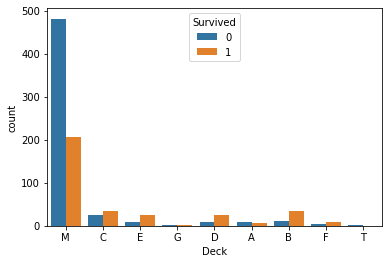

In [27]:
sns.countplot(data = train, x = 'Deck', hue = 'Survived')

- M에서 상대적으로 사람이 많이 죽었다.
- M이라는 값이 생존여부 판단에 의미가 있을것 같다!

#### PClass 시각화

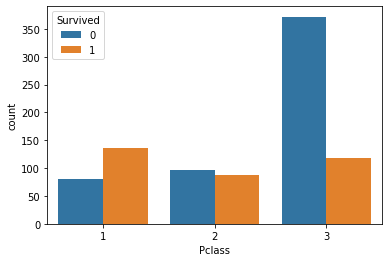

In [28]:
sns.countplot(data = train, x = 'Pclass', hue = 'Survived')

- Pclass가 3인 승객은 사망 확률이 높다!

#### Deck과 Pclass 시각화

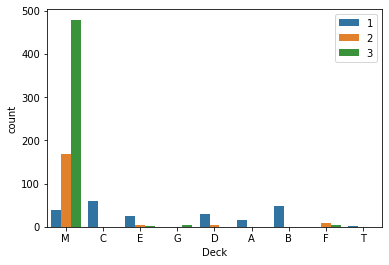

In [29]:
sns.countplot(data=train, x='Deck', hue = 'Pclass')
plt.legend(loc = 'upper right')

#### Sex, Embarked 시각화

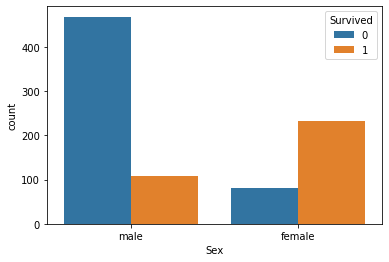

In [30]:
### 성별에 따른 생존/ 사망수치 시각화
sns.countplot(data=train, x='Sex', hue='Survived')

- 남성 : 사망자 비율이 높다!
- 여성 : 생존자 비율이 높다!

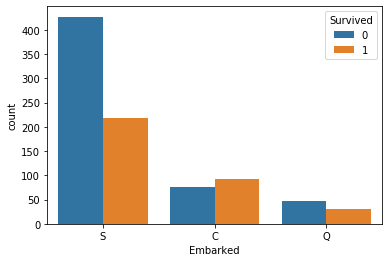

In [31]:
### 승선항에 따른 생존/ 사망수치 시각화
sns.countplot(data=train, x='Embarked', hue = 'Survived')

- S : 사망자 비율 높음
- C : 생존자 비율이 좀 높음
- Q : 사망자 비율이 좀 높음

2) 수치형 데이터 탐색
- Age 시각화 : 성별별 나이에 따른 사망 / 생존 분포 확인!

##### violinplot => boxplot + 데이터의 분포를 확인해 볼 수 있는 kde 

(0, 80)

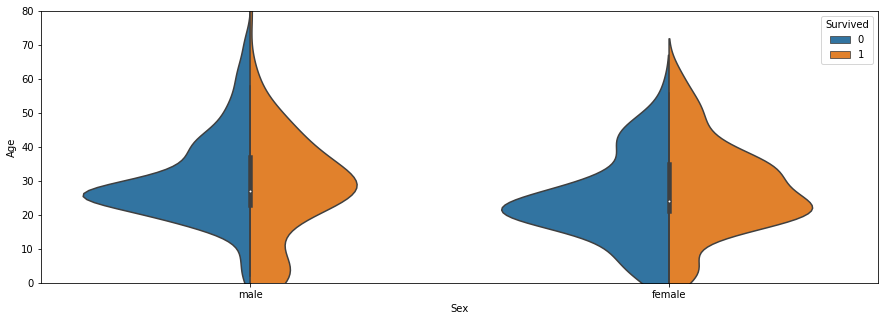

In [32]:
plt.figure(figsize = (15,5))
sns.violinplot(data = train, 
              x = 'Sex', y = 'Age',
              hue = 'Survived', split =True)
plt.ylim(0,80)

- 20 ~ 40 대 사이가 대체적으로 분포가 넓게 나타난다 - > 그 사이의 사망자가 많다!
- 남자 어린아이 생존 분포 넓게 나타남 -> 남자 아이가 좀 더 많이 살아남음

#### Fare 시각화
- 성별별 요금에 따른 사망/생존분포 확인
- 요금 1등칸 : 30pound(375마넌), 2등칸 : 13pound, 3등칸 : 8pound

In [33]:
train['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

(0, 300)

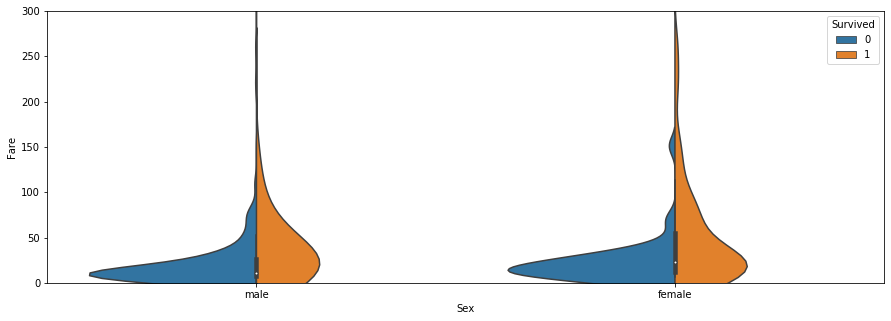

In [34]:
#x축 : Sex/y축 : Fare/ hue : Survived
plt.figure(figsize=(15,5))
sns.violinplot( data=train,
    x = 'Sex', y = 'Fare', hue = 'Survived',
              split=True)
plt.ylim(0,300)

- 요금값이 낮을수록 사망자 비율이 높당!

In [35]:
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

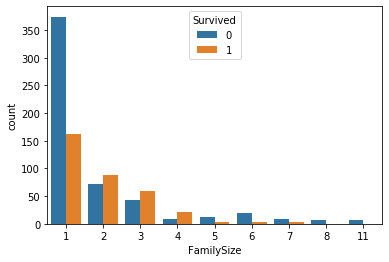

In [36]:
sns.countplot(data=train, x = 'FamilySize', hue = 'Survived')

- 가족수가 1일때 사망비율이 높다!, 2~4 까지는 생존비율 높고, 5 ~ 사망비율 높다

In [37]:
# 숫자형을 범주형으로 : binning (사소한 관찰의 오류를 줄여줄수 있담!)

In [38]:
# cut 함수!
bins = [0,1,4,11] # 1 , 2 - 4 , 5 - 11
labels = ['Alone','Small','Large']
train['FamilyGroup'] = pd.cut(train['FamilySize'],bins = bins, labels = labels)

In [39]:
test['FamilyGroup'] = pd.cut(test['FamilySize'],bins = bins, labels = labels)

- Name의 중간 호칭만 추출해보자!

In [40]:
train['Name']

PassengerId
1                                Braund, Mr. Owen Harris
2      Cumings, Mrs. John Bradley (Florence Briggs Th...
3                                 Heikkinen, Miss. Laina
4           Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                               Allen, Mr. William Henry
                             ...                        
887                                Montvila, Rev. Juozas
888                         Graham, Miss. Margaret Edith
889             Johnston, Miss. Catherine Helen "Carrie"
890                                Behr, Mr. Karl Howell
891                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [41]:
train.loc[1,'Name'].split(',')[1].split('.')[0].strip()

'Mr'

In [42]:
train['Name'][1].split(',')[1].split('.')[0].strip()

'Mr'

In [43]:
def split_title(x) :
    return x.split(',')[1].split('.')[0].strip()

In [44]:
train['Initial'] = train['Name'].apply(split_title)
test['Initial'] = test['Name'].apply(split_title)

In [45]:
train.drop('Name',axis=1,inplace=True)
test.drop('Name',axis=1,inplace=True)

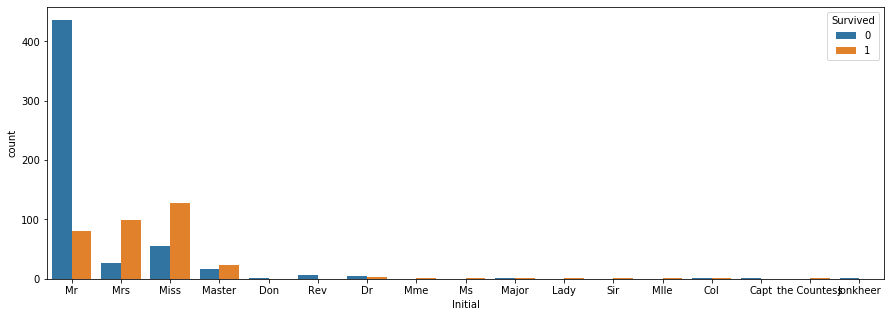

In [46]:
plt.figure(figsize=(15,5))
sns.countplot(data= train, x = 'Initial', hue = 'Survived')

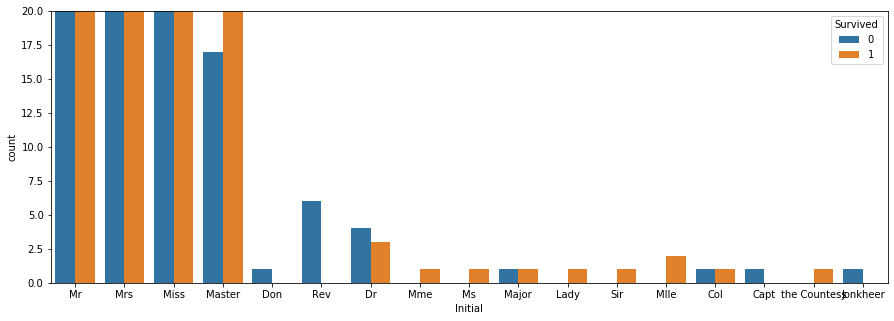

In [47]:
plt.figure(figsize=(15,5))
plt.ylim(0,20)
sns.countplot(data = train, x = 'Initial', hue = 'Survived')

In [48]:
train['Initial'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [49]:
test['Initial'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
      dtype=object)

In [50]:
train['Initial'].replace(['Mlle','Mme' ,'Ms',  'Dr', 'Major','Lady','the Countess','Jonkheer','Col',  'Rev',  'Capt','Sir','Don','Dona'],
                         ['Miss','Miss','Miss','Mrs','Mr',   'Mrs', 'Mrs',        'Other',    'Other','Other','Mr',  'Mr',  'Mr', 'Miss'], inplace = True)
test['Initial'].replace(['Mlle','Mme' ,'Ms',  'Dr', 'Major','Lady','the Countess','Jonkheer','Col',  'Rev',  'Capt','Sir','Don','Dona'],
                         ['Miss','Miss','Miss','Mrs','Mr',   'Mrs', 'Mrs',        'Other',    'Other','Other','Mr',  'Mr',  'Mr', 'Miss'], inplace = True)

In [51]:
train['Initial'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Other'], dtype=object)

In [52]:
test['Initial'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Other'], dtype=object)

### 티켓 정보

In [53]:
# 필요없는 데이터라 생각하여 날림
train.drop('Ticket', axis= 1, inplace = True)
test.drop('Ticket', axis= 1, inplace = True)

In [54]:
train2 = train.copy()
test2 = test.copy()

In [55]:
train['FamilyGroup'] = train['FamilyGroup'].astype('object')

In [56]:
train['Sex'] = train['Sex'].map({ 'male' : 0, 'female' : 1})
test['Sex'] = test['Sex'].map({ 'male' : 0, 'female' : 1})

In [57]:
train['Embarked'] = train['Embarked'].map({ 'C' : 0, 'Q' : 1, 'S' : 2})
test['Embarked'] = test['Embarked'].map({ 'C' : 0, 'Q' : 1, 'S' : 2})

train['Deck'] = train['Deck'].map({'A': 0, 'B' : 1, 'C' : 2, 'D' : 3, 'E' : 4, 'F' : 5, 'G' : 6, 'M' : 7, 'T' : 8})
test['Deck'] = test['Deck'].map({'A': 0, 'B' : 1, 'C' : 2, 'D' : 3, 'E' : 4, 'F' : 5, 'G' : 6, 'M' : 7, 'T' : 8})

train['FamilyGroup'] = train['FamilyGroup'].map({'Alone' : 0, 'Small' : 1, 'Large' : 2})
test['FamilyGroup'] = test['FamilyGroup'].map({'Alone' : 0, 'Small' : 1, 'Large' : 2})

train['Initial'] = train['Initial'].map({'Master' : 0, 'Miss' : 1, 'Mr' : 2, 'Mrs' : 3, 'Other' :4 })
test['Initial'] = test['Initial'].map({'Master' : 0, 'Miss' : 1, 'Mr' : 2, 'Mrs' : 3, 'Other' :4 })

In [58]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,FamilySize,FamilyGroup,Initial
PassengerId,,,,,,,,,,,,
1,0,3,0,22,1,0,7.2500,2,7,2,1,2
2,1,1,1,38,1,0,71.2833,0,2,2,1,3
3,1,3,1,26,0,0,7.9250,2,7,1,0,1
4,1,1,1,35,1,0,53.1000,2,2,2,1,3
5,0,3,0,35,0,0,8.0500,2,7,1,0,2


### 상관관계분석

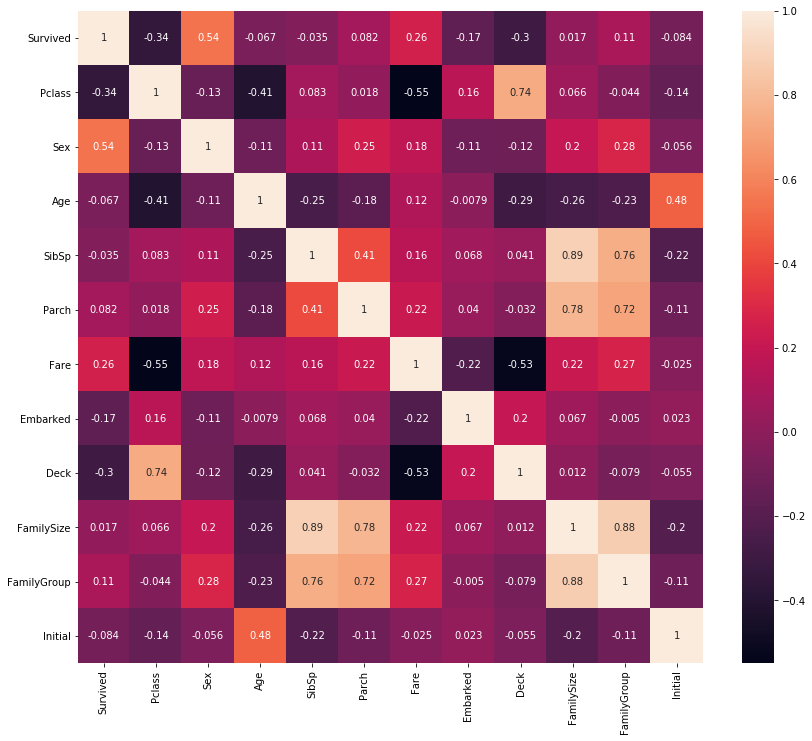

In [59]:
plt.figure(figsize = (14, 12))
sns.heatmap( train.corr(), annot = True)

### 특징 선택
- 범주형 데이터 인코딩
- 전체 데이터 이용 학습
- 상관계수, decision tree 중요도 활용 특성고르기

In [60]:
y_train = train['Survived']
X_train = train.drop('Survived', axis = 1)
X_test = test

In [61]:
X_train.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Deck',
       'FamilySize', 'FamilyGroup', 'Initial'],
      dtype='object')

In [62]:
cat_feature = ['Pclass', 'Embarked', 'Deck','FamilyGroup', 'Initial']

In [63]:
for i in cat_feature :
    dummy = pd.get_dummies(X_train[i], prefix = i)
    X_train = pd.concat([X_train, dummy], axis =1)
    X_train.drop(i, axis= 1, inplace = True)

In [64]:
X_train.head()

,Sex,Age,SibSp,Parch,Fare,FamilySize,Pclass_1,Pclass_2,Pclass_3,Embarked_0,...,Deck_7,Deck_8,FamilyGroup_0,FamilyGroup_1,FamilyGroup_2,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,22,1,0,7.2500,2,0,0,1,0,...,1,0,0,1,0,0,0,1,0,0
2,1,38,1,0,71.2833,2,1,0,0,1,...,0,0,0,1,0,0,0,0,1,0
3,1,26,0,0,7.9250,1,0,0,1,0,...,1,0,1,0,0,0,1,0,0,0
4,1,35,1,0,53.1000,2,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
5,0,35,0,0,8.0500,1,0,0,1,0,...,1,0,1,0,0,0,0,1,0,0


In [65]:
for i in cat_feature :
    dummy = pd.get_dummies(X_test[i], prefix = i)
    X_test = pd.concat([X_test, dummy], axis =1)
    X_test.drop(i, axis= 1, inplace = True)

In [66]:
X_test.head()

,Sex,Age,SibSp,Parch,Fare,FamilySize,Pclass_1,Pclass_2,Pclass_3,Embarked_0,...,Deck_6,Deck_7,FamilyGroup_0,FamilyGroup_1,FamilyGroup_2,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
PassengerId,,,,,,,,,,,,,,,,,,,,,
892,0,34,0,0,7.8292,1,0,0,1,0,...,0,1,1,0,0,0,0,1,0,0
893,1,47,1,0,7.0000,2,0,0,1,0,...,0,1,0,1,0,0,0,0,1,0
894,0,62,0,0,9.6875,1,0,1,0,0,...,0,1,1,0,0,0,0,1,0,0
895,0,27,0,0,8.6625,1,0,0,1,0,...,0,1,1,0,0,0,0,1,0,0
896,1,22,1,1,12.2875,3,0,0,1,0,...,0,1,0,1,0,0,0,0,1,0


In [67]:
print(X_train.shape)
print(X_test.shape)

(891, 29)
(418, 28)


In [68]:
set(X_train.columns) - set(X_test.columns)

{'Deck_8'}

In [69]:
from sklearn.neighbors import KNeighborsClassifier

In [70]:
model = KNeighborsClassifier( n_neighbors= 3)

In [71]:
from sklearn.model_selection import cross_val_score

In [72]:
result = cross_val_score(model, X_train, y_train, cv = 5)

In [73]:
result.mean()

0.7306509321448749

In [74]:
model2 = DecisionTreeClassifier(max_depth=5)
model2.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [75]:
from sklearn.tree import export_graphviz
import graphviz

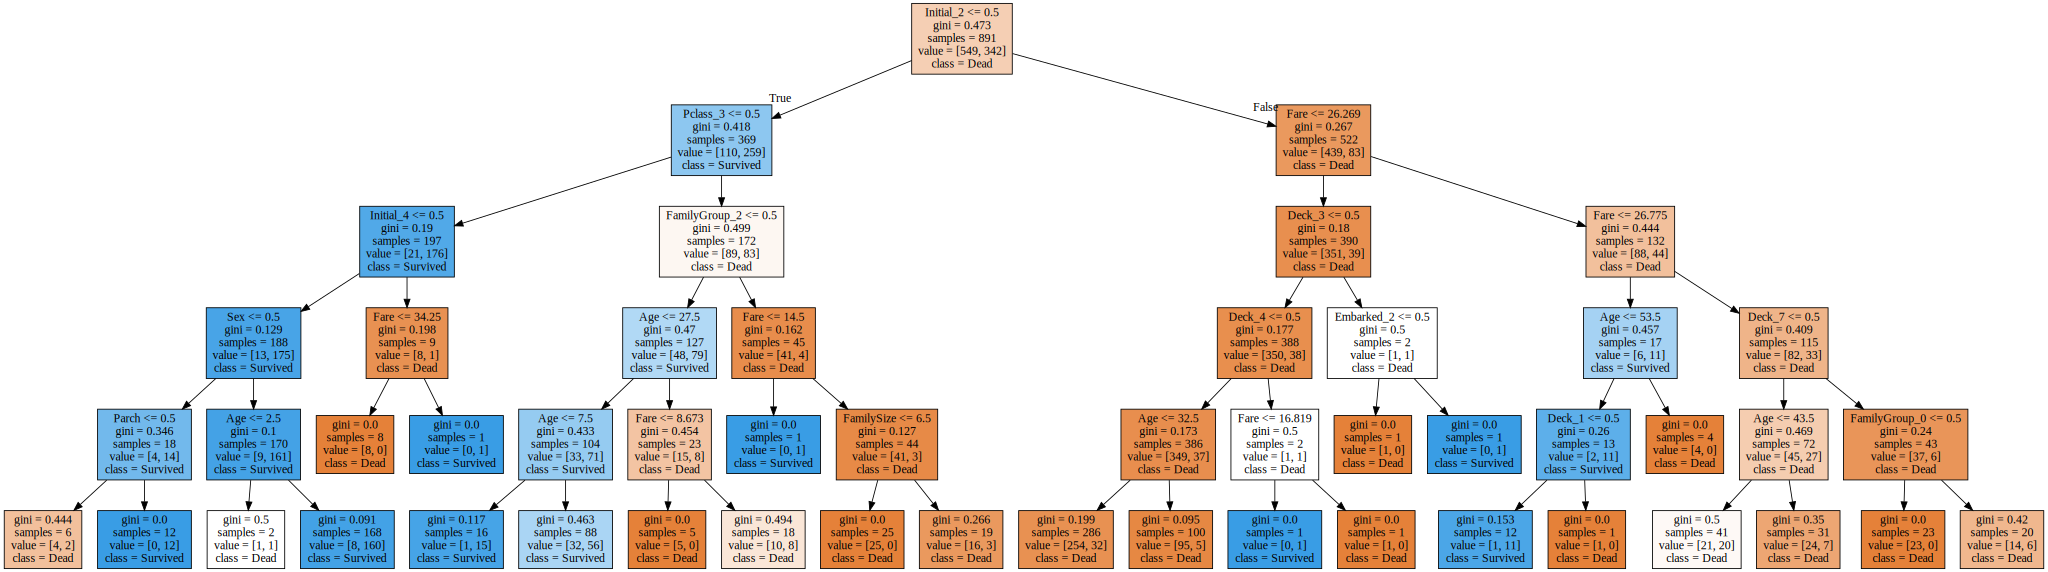

In [76]:
export_graphviz(model2,out_file='tree.dot', class_names= ['Dead','Survived'],
               feature_names= X_train.columns, impurity= True, filled = True)
with open('tree.dot', encoding = 'utf8') as f :
    dot_graph = f.read()

display(graphviz.Source(dot_graph))

In [77]:
result = cross_val_score( model2, X_train, y_train, cv= 5)

In [79]:
result.mean()

0.8170861841692298